In [1]:
import numpy as np
import pandas as pd

In [2]:
import random

In [3]:
from tqdm import tqdm

In [4]:
import re
import os

In [99]:
import time

In [5]:
from collections import Counter

In [6]:
from sklearn.model_selection import train_test_split

#### PyTorch

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader

import torch.optim as optim

In [69]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [8]:
import torchinfo

#### Metrics

In [9]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [10]:
from Levenshtein import distance as levenshtein_distance

#### Visualisation

In [11]:
import matplotlib
import matplotlib.pyplot as plt

In [12]:
import scienceplots

plt.style.use('science')
%config InlineBackend.figure_format = 'retina'

lables_fs = 16
ticks_fs = 12

In [13]:
import seaborn as sns

# Baseline reference: [X-Punctuator](https://github.com/kaituoxu/X-Punctuator/tree/master)

## Predicting only intrinsic punctuation

### Load data

In [14]:
prepared_dir = '../data/prepared'
filename_csv = '02_punct_pushkin.csv'

In [15]:
# load saved dataset
data_df = pd.read_csv(os.path.join(prepared_dir, filename_csv), index_col=0)
data_df.shape

(4456, 3)

In [16]:
pd.options.display.max_colwidth = 150
data_df.sample(5)

,input,input_lemma,new_target
327,я слышал сказал я довольно некстати что на вашу крепость собираются напасть башкирцы,я слышать сказать я довольно некстати что на ваш крепость собираться напасть башкирец,S C S S S C S S S S S S F
4101,вижу как теперь самого хозяина человека лет пятидесяти свежего и бодрого и его длинный зеленый сертук с тремя медалями на полинялых лентах,видеть как теперь сам хозяин человек год пятьдесят свежий и бодрый и его длинный зеленый сертук с три медаль на полинялый лента,C S C S C S S C S S C S S S S S S S S S S F
2577,казанка была запружена мертвыми телами пять тысяч пленных и девять пушек остались в руках у победителя,казанка быть запрудить мертвый тело пять тысяча пленный и девять пушка остаться в рука у победитель,S S S S C S S S S S S S S S S F
1782,начальство поручено яицкому коменданту подполковнику симонову,начальство поручить яицкий комендант подполковник симонов,S S S C S F
862,я за то тебя детинушка пожалую середи поля хоромами высокими что двумя ли столбами с перекладиной,я за тот ты детинушка пожалую середь поле хоромы высокий что два ли столб с перекладиной,S S S C C S S S S C S S S S S F


### Vocab

In [46]:
IGNORE_ID = -1  # token id to ignore

In [31]:
unk_token = '<UNK>'

In [32]:
word2id = {unk_token: 0, '<END>': 1}
ind_lemma = 2

for ind_sent in data_df.index:
    lemma_sent = data_df.iloc[ind_sent]['input_lemma']
    for lemma in lemma_sent.split():
        if lemma not in word2id.keys():  # new lemma
            word2id[lemma] = ind_lemma
            ind_lemma += 1

In [33]:
len(word2id)

8571

In [241]:
punc2id = {'S': 0, 'C': 1, 'F':2}
id2punc = {v: k for k, v in punc2id.items()}

### Dataset

In [38]:
class PuncDataset(Dataset):
    """Custom Dataset for punctuation prediction"""

    def __init__(self, df, sent_col, target_col):
        self.sentences = df[sent_col]  # all sentences
        self.targets = df[target_col]  # all targets

    def __len__(self):
        """Return number of sentences"""
        return len(self.sentences)

    def __getitem__(self, index):
        """Return one Tensor pair of (input id sequence, punc id sequence)"""
        sentence = self.sentences[index]
        target = self.targets[index]
        
        word_id_seq, punc_id_seq = self._preprocess(sentence, target)
        return word_id_seq, punc_id_seq

    def _preprocess(self, sentence, target):
        """Convert txt sequence to word-id-seq and punc-id-seq"""
        input_seq = []
        for word in sentence.split():
            input_seq.append(word2id.get(word, unk_token))

        output_seq = []
        for punc in target.split():
            output_seq.append(punc2id.get(punc))

        assert len(input_seq) == len(output_seq)
        # input_seq.append(self.word2id["<END>"])
        # output_seq.append(self.punc2id[punc])
        return torch.LongTensor(input_seq), torch.LongTensor(output_seq)

In [43]:
data_ds = PuncDataset(
    df=data_df, 
    sent_col='input_lemma', 
    target_col='new_target'
)

print(len(data_ds))  # dataset length

4456


In [44]:
data_ds[1111]  # example of dataset element

(tensor([1499,    6,  790, 1351,   78,  113,    6, 1206,    2,  583, 2849, 3243]),
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2]))

### Batches

In [65]:
class RandomBatchSampler(object):
    """
    Yields of mini-batch of indices, sequential within the batch, random between batches.
    
    I.e. it works like bucket, but it also supports random between batches.
    Helpful for minimizing padding while retaining randomness with variable length inputs.

    Args:
        data_source (Dataset): dataset to sample from.
        batch_size (int): Size of mini-batch.
        drop_last (bool): If ``True``, the sampler will drop the last batch if
            its size would be less than ``batch_size``
    """

    def __init__(self, data_source, batch_size, drop_last):
        # impl sequential within the batch
        self.sampler = torch.randperm(len(data_source)).tolist() # random order of all sentences
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.random_batches = self._make_batches()  # impl random between batches

    def _make_batches(self):
        indices = [i for i in self.sampler]
        batches = [
            indices[i:i + self.batch_size]
            for i in range(0, len(indices), self.batch_size)
        ]
        
        if self.drop_last and len(self.sampler) % self.batch_size > 0:  # mix batches order
            random_indices = torch.randperm(len(batches) - 1).tolist() + [len(batches) - 1]  # batches order
        else:
            random_indices = torch.randperm(len(batches)).tolist()
        
        return [batches[i] for i in random_indices]

    def __iter__(self):
        for batch in self.random_batches:
            yield batch

    def __len__(self):
        return len(self.random_batches)

In [67]:
class SentencesCollate(object):
    """
    Another way to implement collate_fn passed to DataLoader.
    Use class but not function because this is easier to pass some parameters.
    """
    def __init__(self):
        pass

    def __call__(self, batch, PAD=IGNORE_ID):
        """
        Process one mini-batch samples, such as sorting and padding.
        Args:
            batch: a list of (text sequence, feature sequence)
        Returns:
            input_padded_seqs
            output_padded_seqs
            lengths
        """
        # sort a list by sequence length (descending order) to use pack_padded_sequence
        batch.sort(key=lambda x: len(x[0]), reverse=True)
        # seperate inputs and labels
        input_seqs, label_seqs = zip(*batch)
        # padding
        lengths = [len(seq) for seq in input_seqs]
        input_padded_seqs = torch.zeros(len(input_seqs), max(lengths)).long()
        output_padded_seqs = torch.zeros(len(input_seqs), max(lengths)).fill_(PAD).long()
        
        for i, (input_seq, output_seq) in enumerate(zip(input_seqs, label_seqs)):
            end = lengths[i]
            input_padded_seqs[i, :end] = input_seq[:end]
            output_padded_seqs[i, :end] = output_seq[:end]
            
        return input_padded_seqs, torch.IntTensor(lengths), output_padded_seqs

In [68]:
def build_data_loader(
    df, sent_col, target_col,
    batch_size=1, drop_last=False, num_workers=0
):
    """
    Return data loader for custom dataset
    """
    dataset = PuncDataset(df, sent_col, target_col)
    batch_sampler = RandomBatchSampler(
        dataset,
        batch_size=batch_size,
        drop_last=drop_last
    )
    collate_fn = SentencesCollate()
    
    data_loader = DataLoader(
        dataset, batch_sampler=batch_sampler,
        collate_fn=collate_fn, num_workers=num_workers
    )

    return data_loader

## Model

In [158]:
class LstmPunctuator(nn.Module):
    def __init__(
        self, num_embeddings, embedding_dim,
        hidden_size, num_layers, bidirectional,
        num_class, dropout=0.0
    ):
        super(LstmPunctuator, self).__init__()
        
        # Hyper-parameters
        self.num_embeddings = num_embeddings  # size of the dictionary of embeddings
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_class = num_class
        self.dropout = dropout
        
        # Components
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers,
            batch_first=True,
            bidirectional=bool(bidirectional),
            dropout=self.dropout
        )
        fc_in_dim = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(fc_in_dim, num_class)

    def forward(self, padded_input, input_lengths):
        """
        Args:
            padded_input: N x T
            input_lengths: N
        Returns:
            score: N x T x C
        """
        # Embedding Layer
        padded_input = self.embedding(padded_input)  # N x T x D
        # LSTM Layers
        total_length = padded_input.size(1)  # get the max sequence length
        packed_input = pack_padded_sequence(
            padded_input, input_lengths,
            batch_first=True
        )
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(
            packed_output,
            batch_first=True,
            total_length=total_length
        )
        # Output Layer
        score = self.fc(output)
        return score

    def flatten_parameters(self):
        self.lstm.flatten_parameters()

In [159]:
def num_param(model):
    """
    To count model parameters
    """
    params = 0
    for p in model.parameters():
        tmp = 1
        for x in p.size():
            tmp *= x
        params += tmp
    return params

### Training and validation loops as Class

In [160]:
line = '-' * 85

In [191]:
class Solver(object):
    
    def __init__(self, data, model, criterion, optimizer, args):
        self.tr_loader = data['tr_loader']
        self.cv_loader = data['cv_loader']
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

        # Training config
        self.use_cuda = args['use_cuda']
        self.epochs = args['epochs']
        self.half_lr = args['half_lr']
        self.early_stop = args['early_stop']
        self.max_norm = args['max_norm']
        
        # save and load model
        # self.save_folder = args.save_folder
        # self.checkpoint = args.checkpoint
        # self.continue_from = args.continue_from
        # self.model_path = args.model_path
        
        # logging
        self.print_freq = args['print_freq']
        
        # visualizing loss using visdom
        self.tr_loss = torch.Tensor(self.epochs)
        self.cv_loss = torch.Tensor(self.epochs)

        self._reset()

    def _reset(self):
        self.start_epoch = 0

        self.prev_val_loss = float("inf")
        self.best_val_loss = float("inf")
        self.halving = False
        self.val_no_impv = 0

    def train(self):
        # Train model multi-epoches
        for epoch in range(self.start_epoch, self.epochs):
            # Train one epoch
            print(line)
            print(f'Epoch {epoch + 1}')
            
            self.model.train()  # Turn on BatchNorm & Dropout
            start = time.time()

            tr_avg_loss = self._run_one_epoch(epoch)

            print('\tTrain Summary | Time {0:.2f}s | '
                  'Train Loss {1:.6f}'.format(
                      time.time() - start, tr_avg_loss))
            
            # Validation
            # print(f'Epoch {epoch + 1} validation')
            self.model.eval()  # Turn off Batchnorm & Dropout

            val_loss = self._run_one_epoch(epoch, cross_valid=True)

            print('\tValid Summary | Time {0:.2f}s | '
                  'Valid Loss {1:.6f}'.format(
                      time.time() - start, val_loss))

            # Adjust learning rate (halving)
            if self.half_lr and val_loss >= self.prev_val_loss:
                if self.early_stop and self.halving:
                    print("Already start halving learing rate, it still gets "
                          "too small imporvement, stop training early.")
                    break
                self.halving = True
            if self.halving:
                optim_state = self.optimizer.state_dict()
                optim_state['param_groups'][0]['lr'] = \
                    optim_state['param_groups'][0]['lr'] / 2.0
                self.optimizer.load_state_dict(optim_state)
                print('Learning rate adjusted to: {lr:.6f}'.format(
                    lr=optim_state['param_groups'][0]['lr']))
            self.prev_val_loss = val_loss

            # Save the best model
            self.cv_loss[epoch] = val_loss

    def _run_one_epoch(self, epoch, cross_valid=False):
        start = time.time()
        total_loss = 0

        data_loader = self.tr_loader if not cross_valid else self.cv_loader

        # Main Loop
        for i, (data) in enumerate(data_loader):
            padded_input, input_lengths, padded_target = data
            if self.use_cuda:
                padded_input = padded_input.cuda()
                input_lengths = input_lengths.cuda()
                padded_target = padded_target.cuda()
            pred = self.model(padded_input, input_lengths)
            pred = pred.view(-1, pred.size(-1))
            loss = self.criterion(pred, padded_target.view(-1))
            if not cross_valid:
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(),
                                               self.max_norm)
                self.optimizer.step()

            total_loss += loss.item()

            if False:  # i % self.print_freq == 0:
                print(
                    '\t\tIter {0} | Average Loss {1:.3f} | '
                    'Current Loss {2:.6f} | {3:.1f} ms/batch'.format(
                    i + 1, total_loss / (i + 1),
                    loss.item(), 1000 * (time.time() - start) / (i + 1)),
                    flush=True
                )

        return total_loss / (i + 1)

### Training

In [217]:
args = {
    'bs': 25,
    'num_workers': 0,
    'use_cuda': 0,
    'epochs': 1,
    'half_lr': 0,
    'early_stop': 0,
    'max_norm': 10,
    'lr': 1e-3,
    'l2': 0.0,  # weight decay (L2 penalty)
    'print_freq': 100,  # frequency of printing training infomation
}

splitting_random_state = 78
test_ratio = 0.25

In [218]:
# data splitting
train, test = train_test_split(data_df, test_size=test_ratio, random_state=splitting_random_state)

In [219]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [220]:
tr_loader = build_data_loader(
    train, sent_col='input_lemma', target_col='new_target',
    batch_size=args['bs'], drop_last=False,
    num_workers=args['num_workers']
)
cv_loader = build_data_loader(
    test, sent_col='input_lemma', target_col='new_target',
    batch_size=args['bs'], drop_last=False
)
data = {'tr_loader': tr_loader, 'cv_loader': cv_loader}

# Build model
model = LstmPunctuator(
    num_embeddings=len(word2id), embedding_dim=16,
    hidden_size=64, num_layers=1, bidirectional=1,
    num_class=len(punc2id)
)
# print(model)
print("Number of parameters: %d" % num_param(model))

Number of parameters: 179507


In [221]:
# Build criterion
criterion = torch.nn.CrossEntropyLoss(ignore_index=IGNORE_ID)
# Build optimizer
optimizier = torch.optim.Adam(
    model.parameters(), lr=args['lr'],
    weight_decay=args['l2']
)

In [222]:
# Build Solver
torch.manual_seed(48)

solver = Solver(data, model, criterion, optimizier, args)
solver.train()

-------------------------------------------------------------------------------------
Epoch 1
	Train Summary | Time 1.40s | Train Loss 0.631759
	Valid Summary | Time 1.55s | Valid Loss 0.501120
-------------------------------------------------------------------------------------
Epoch 2
	Train Summary | Time 1.35s | Train Loss 0.455041
	Valid Summary | Time 1.50s | Valid Loss 0.415835
-------------------------------------------------------------------------------------
Epoch 3
	Train Summary | Time 1.41s | Train Loss 0.387576
	Valid Summary | Time 1.61s | Valid Loss 0.372592
-------------------------------------------------------------------------------------
Epoch 4
	Train Summary | Time 1.80s | Train Loss 0.350948
	Valid Summary | Time 1.94s | Valid Loss 0.350172
-------------------------------------------------------------------------------------
Epoch 5
	Train Summary | Time 1.36s | Train Loss 0.327270
	Valid Summary | Time 1.49s | Valid Loss 0.336604
------------------------------

### Metrics

In [224]:
test_loader = build_data_loader(
    test, sent_col='input_lemma', target_col='new_target',
    batch_size=1, drop_last=False
)

In [242]:
all_test_targets = []  # by markers
all_test_preds = []

solver.model.eval()

for i, (data) in enumerate(test_loader):
    padded_input, input_lengths, padded_target = data
    all_test_targets.append(' '.join([id2punc[ix.item()] for ix in padded_target[0]]))
    
    pred = solver.model(padded_input, input_lengths)
    pred = torch.argmax(pred.view(-1, pred.size(-1)), dim=1)
    all_test_preds.append(' '.join([id2punc[ix.item()] for ix in pred]))

    assert len(pred) == len(padded_target[0])

In [243]:
target_vs_pred_df = pd.DataFrame()

target_vs_pred_df['target'] = all_test_targets
target_vs_pred_df['predicted'] = all_test_preds

In [244]:
target_vs_pred_df

,target,predicted
0,S S C S S C S S S S S S S C S S S S S S S F,S S S S S S S S S S S S S C S S S S S S S F
1,S S S S S C S S S S C S C S S S S S S C S S F,S S S S S S S S S S S S C S S S S S S S S S F
2,S C S C S S S S C S S S F,S S S C S S S S C S S S F
3,S S S S S C S C S S S C S S S F,S S S S S C S C S S S S S S S F
4,S S S S S S S S C S S S S S F,S S S S S S S S C S S S S S F
...,...,...
1109,S C S C S S S S S F,S S S C S S S S S F
1110,S S S S C S S S S S F,C S S S S S S S S S F
1111,S S C S S S S F,S S S S S S S F
1112,S S C C S S S C S S S S S S F,S S C S S S S S S S S S S S F


#### Precision, Recall, $F_1$

In [245]:
def return_separate_punct(target_vs_pred_df):
    test_all_punc_target = []  # list of all punctuation
    test_all_punc_preds = []
    
    for target_this, predicted_this in zip(target_vs_pred_df['target'], target_vs_pred_df['predicted']):
        test_all_punc_target.extend(target_this.split(' '))
        test_all_punc_preds.extend(predicted_this.split(' '))
    
    assert len(test_all_punc_target) == len(test_all_punc_preds)
    
    return test_all_punc_target, test_all_punc_preds

In [246]:
test_all_punc_target, test_all_punc_preds = return_separate_punct(target_vs_pred_df)

cm = confusion_matrix(test_all_punc_target, test_all_punc_preds)
# precision = TP / (TP + FP)
precision = precision_score(test_all_punc_target, test_all_punc_preds, average=None, zero_division=np.nan)
# recall = TP / (TP + FN)
recall = recall_score(test_all_punc_target, test_all_punc_preds, average=None, zero_division=np.nan)
# f1 = 2TP / (2TP + FP + FN)
f1 = f1_score(test_all_punc_target, test_all_punc_preds, average=None)

In [252]:
END_PUNC = ['F']
INTR_PUNC = ['S', 'C']

NAMES_PUNC = {
    'S': 'space (` `)',
    'C': 'comma (`,`)',
    'F': 'end of sent',
}

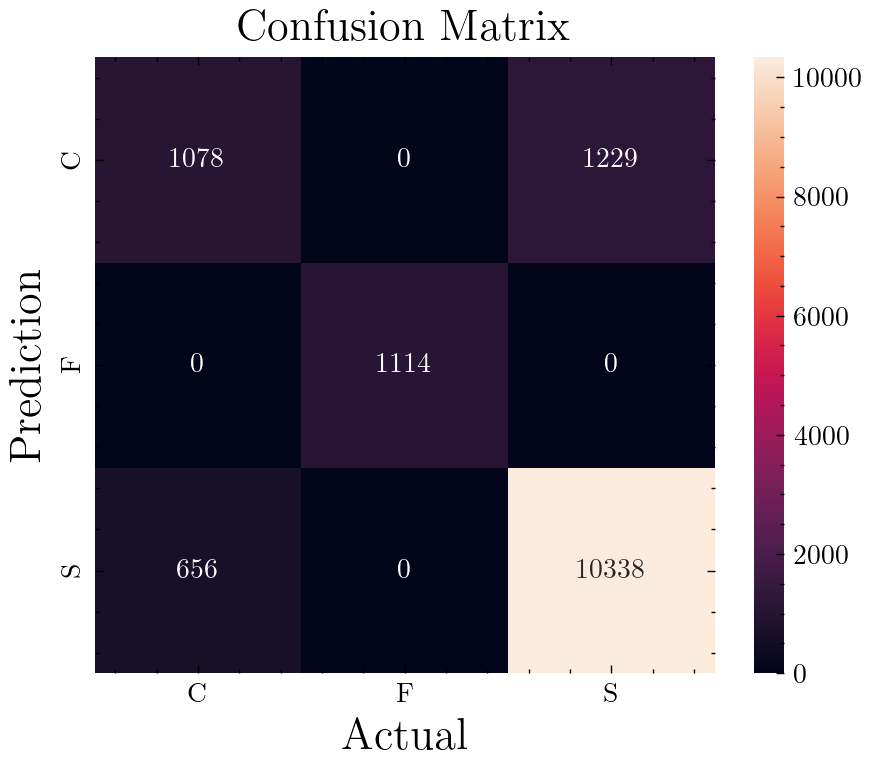

In [253]:
fig, ax = plt.subplots(figsize=(5, 4))

# create a confusion matrix
# cm = confusion_matrix(test_all_punc_target, test_all_punc_preds) / n_experiments
classes = sorted(END_PUNC + INTR_PUNC)  # alphabetic order

# plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.ylabel('Prediction', fontsize=lables_fs)
plt.xlabel('Actual', fontsize=lables_fs)
plt.title(f'Confusion Matrix', fontsize=lables_fs)
plt.show()

In [254]:
metrics_names = ['Precision', 'Recall', 'F1 score']
metrics = {'Precision': precision, 'Recall': recall, 'F1 score': f1}
col_w = 18

print(' ' * col_w + '|' + ''.join([f"{NAMES_PUNC[token] + (col_w - len(NAMES_PUNC[token])) * ' '}|" for token in classes]))  # header
print(''.join(['-' * col_w + '|' for _ in range(len(classes) + 1)]) )
for ind, metric_name in enumerate(metrics_names):
    row = f"{metric_name + (col_w - len(metric_name)) * ' '}|"
    for score in metrics[metric_name]:
        score_str = f'{score:.6f}'
        row += f"{score_str + (col_w - len(score_str)) * ' '}|"
    print(row)

                  |comma (`,`)       |end of sent       |space (` `)       |
------------------|------------------|------------------|------------------|
Precision         |0.621684          |1.000000          |0.893749          |
Recall            |0.467274          |1.000000          |0.940331          |
F1 score          |0.533531          |1.000000          |0.916449          |


#### Levenshtein distance

In [250]:
target_vs_pred_df['levenshtein'] = target_vs_pred_df.apply(
    lambda row: levenshtein_distance(row.target, row.predicted),
    axis = 1
)

In [251]:
print(f"\tMean: {target_vs_pred_df['levenshtein'].mean()}")
print(f"\tMIN : {target_vs_pred_df['levenshtein'].min()}")
print(f"\tMAX : {target_vs_pred_df['levenshtein'].max()}")

	Mean: 1.689407540394973
	MIN : 0
	MAX : 13


## Trying to predict all punctuation

In [255]:
filename_csv = '01_punct_pushkin.csv'

In [256]:
# load saved dataset
data_df2 = pd.read_csv(os.path.join(prepared_dir, filename_csv), index_col=0)
data_df2.shape

(4456, 4)

In [257]:
data_df2.sample(5)

,input,input_lemma,input_pos,target
3253,когда встали изо стола антон пафнутьич стал вертеться около молодого француза покрякивая и откашливаясь и наконец обратился к нему с изъяснением,когда встать из стол антон пафнутьич стать вертеться около молодой француз покрякивая и откашливаясь и наконец обратиться к он с изъяснение,SCONJ VERB ADP NOUN NOUN NOUN VERB VERB ADP ADJ NOUN NOUN CCONJ NOUN CCONJ ADV VERB ADP PRON ADP NOUN,S S S C S S S S S S C S S C S S S S S S P
3141,накануне праздника гости начали съезжаться иные останавливались в господском доме и во флигелях другие у приказчика третьи у священника четвертые ...,накануне праздник гость начать съезжаться иной останавливаться в господский дом и в флигель другой у приказчик третий у священник четвертый у зажи...,ADP NOUN NOUN VERB VERB ADJ VERB ADP ADJ NOUN CCONJ ADP NOUN ADJ ADP NOUN ADJ ADP NOUN ADJ ADP ADJ NOUN,S S S S C S S S S S S S C S S C S S C S S S P
3508,папенька сердит и запретил всему дому вас слушаться но велите мне сделать что вам угодно и я для вас все сделаю,папенька сердитый и запретить весь дом вы слушаться но велеть я сделать что вы угодный и я для вы весь сделать,ADJ NOUN CCONJ VERB DET NOUN PRON VERB CCONJ VERB PRON VERB PRON PRON ADJ CCONJ PRON ADP PRON PRON VERB,S S S S S S S C S S S C S S C S S S S S P
2461,во все время пугачев лежал в своей палатке жестоко страдая от раны полученной им под магнитною,в весь время пугачев лежать в свой палатка жестоко страдать от рана получить он под магнитный,ADP DET NOUN NOUN VERB ADP DET NOUN ADV VERB ADP NOUN VERB PRON ADP NOUN,S S S S S S S C S S S C S S S P
1647,вы были для меня более чем благодетели,вы быть для я более чем благодетель,PRON AUX ADP PRON ADV SCONJ VERB,S S S S C S P


### Vocab

In [259]:
punc2id = {'S': 0, 'C': 1, 'P': 2, 'Q': 3, 'EX': 4}
id2punc = {v: k for k, v in punc2id.items()}

### Training

In [291]:
args_2 = {
    'bs': 20,
    'num_workers': 0,
    'use_cuda': 0,
    'epochs': 11,
    'half_lr': 0,
    'early_stop': 0,
    'max_norm': 5,
    'lr': 1e-3,
    'l2': 0.0,  # weight decay (L2 penalty)
    'print_freq': 100,  # frequency of printing training infomation
}

In [292]:
# data splitting
train_2, test_2 = train_test_split(data_df2, test_size=test_ratio, random_state=splitting_random_state)

In [293]:
train_2.reset_index(drop=True, inplace=True)
test_2.reset_index(drop=True, inplace=True)

In [294]:
tr_loader_2 = build_data_loader(
    train_2, sent_col='input_lemma', target_col='target',
    batch_size=args_2['bs'], drop_last=False,
    num_workers=args_2['num_workers']
)
cv_loader_2 = build_data_loader(
    test_2, sent_col='input_lemma', target_col='target',
    batch_size=args_2['bs'], drop_last=False
)
data_2 = {'tr_loader': tr_loader_2, 'cv_loader': cv_loader_2}

# Build model
model_2 = LstmPunctuator(
    num_embeddings=len(word2id), embedding_dim=16,
    hidden_size=64, num_layers=1, bidirectional=1,
    num_class=len(punc2id)
)
# print(model)
print("Number of parameters: %d" % num_param(model_2))

Number of parameters: 179765


In [295]:
# Build criterion
criterion_2 = torch.nn.CrossEntropyLoss(ignore_index=IGNORE_ID)
# Build optimizer
optimizier_2 = torch.optim.Adam(
    model_2.parameters(), lr=args_2['lr'],
    weight_decay=args_2['l2']
)

In [296]:
# Build Solver
torch.manual_seed(48)

solver_2 = Solver(data_2, model_2, criterion_2, optimizier_2, args_2)
solver_2.train()

-------------------------------------------------------------------------------------
Epoch 1
	Train Summary | Time 2.95s | Train Loss 0.736881
	Valid Summary | Time 3.40s | Valid Loss 0.516666
-------------------------------------------------------------------------------------
Epoch 2
	Train Summary | Time 4.16s | Train Loss 0.474464
	Valid Summary | Time 4.69s | Valid Loss 0.442783
-------------------------------------------------------------------------------------
Epoch 3
	Train Summary | Time 4.79s | Train Loss 0.415233
	Valid Summary | Time 5.70s | Valid Loss 0.402969
-------------------------------------------------------------------------------------
Epoch 4
	Train Summary | Time 3.69s | Train Loss 0.378178
	Valid Summary | Time 4.04s | Valid Loss 0.380438
-------------------------------------------------------------------------------------
Epoch 5
	Train Summary | Time 3.07s | Train Loss 0.351826
	Valid Summary | Time 3.40s | Valid Loss 0.365476
------------------------------

### Metrics

In [297]:
test_loader_2 = build_data_loader(
    test_2, sent_col='input_lemma', target_col='target',
    batch_size=1, drop_last=False
)

In [298]:
all_test_targets = []  # by markers
all_test_preds = []

solver_2.model.eval()

for i, (data) in enumerate(test_loader_2):
    padded_input, input_lengths, padded_target = data
    all_test_targets.append(' '.join([id2punc[ix.item()] for ix in padded_target[0]]))
    
    pred = solver_2.model(padded_input, input_lengths)
    pred = torch.argmax(pred.view(-1, pred.size(-1)), dim=1)
    all_test_preds.append(' '.join([id2punc[ix.item()] for ix in pred]))

    assert len(pred) == len(padded_target[0])

In [299]:
target_vs_pred_df = pd.DataFrame()

target_vs_pred_df['target'] = all_test_targets
target_vs_pred_df['predicted'] = all_test_preds

#### Precision, Recall, $F_1$

In [300]:
def return_separate_punct(target_vs_pred_df):
    test_all_punc_target = []  # list of all punctuation
    test_all_punc_preds = []
    
    for target_this, predicted_this in zip(target_vs_pred_df['target'], target_vs_pred_df['predicted']):
        test_all_punc_target.extend(target_this.split(' '))
        test_all_punc_preds.extend(predicted_this.split(' '))
    
    assert len(test_all_punc_target) == len(test_all_punc_preds)
    
    return test_all_punc_target, test_all_punc_preds

In [301]:
test_all_punc_target, test_all_punc_preds = return_separate_punct(target_vs_pred_df)

cm = confusion_matrix(test_all_punc_target, test_all_punc_preds)
# precision = TP / (TP + FP)
precision = precision_score(test_all_punc_target, test_all_punc_preds, average=None, zero_division=np.nan)
# recall = TP / (TP + FN)
recall = recall_score(test_all_punc_target, test_all_punc_preds, average=None, zero_division=np.nan)
# f1 = 2TP / (2TP + FP + FN)
f1 = f1_score(test_all_punc_target, test_all_punc_preds, average=None)

In [302]:
END_PUNC = ['P', 'EX', 'Q']
INTR_PUNC = ['S', 'C']

NAMES_PUNC = {
    'S': 'space (` `)',
    'C': 'comma (`,`)',
    'P': 'period (`.`)',
    'EX': 'exclamation (`!`)',
    'Q': 'question (`?`)'
}

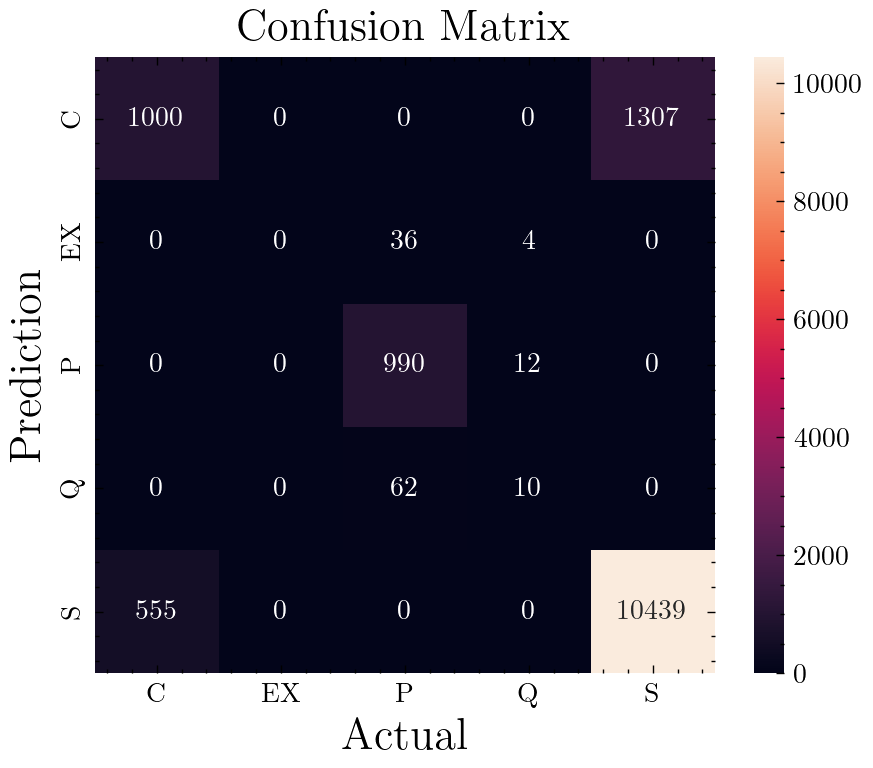

In [303]:
fig, ax = plt.subplots(figsize=(5, 4))

# create a confusion matrix
# cm = confusion_matrix(test_all_punc_target, test_all_punc_preds) / n_experiments
classes = sorted(END_PUNC + INTR_PUNC)  # alphabetic order

# plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.ylabel('Prediction', fontsize=lables_fs)
plt.xlabel('Actual', fontsize=lables_fs)
plt.title(f'Confusion Matrix', fontsize=lables_fs)
plt.show()

In [304]:
metrics_names = ['Precision', 'Recall', 'F1 score']
metrics = {'Precision': precision, 'Recall': recall, 'F1 score': f1}
col_w = 18

print(' ' * col_w + '|' + ''.join([f"{NAMES_PUNC[token] + (col_w - len(NAMES_PUNC[token])) * ' '}|" for token in classes]))  # header
print(''.join(['-' * col_w + '|' for _ in range(len(classes) + 1)]) )
for ind, metric_name in enumerate(metrics_names):
    row = f"{metric_name + (col_w - len(metric_name)) * ' '}|"
    for score in metrics[metric_name]:
        score_str = f'{score:.6f}'
        row += f"{score_str + (col_w - len(score_str)) * ' '}|"
    print(row)

                  |comma (`,`)       |exclamation (`!`) |period (`.`)      |question (`?`)    |space (` `)       |
------------------|------------------|------------------|------------------|------------------|------------------|
Precision         |0.643087          |nan               |0.909926          |0.384615          |0.888728          |
Recall            |0.433463          |0.000000          |0.988024          |0.138889          |0.949518          |
F1 score          |0.517866          |0.000000          |0.947368          |0.204082          |0.918118          |


#### Levenshtein distance

In [305]:
target_vs_pred_df['levenshtein'] = target_vs_pred_df.apply(
    lambda row: levenshtein_distance(row.target, row.predicted),
    axis = 1
)

In [306]:
print(f"\tMean: {target_vs_pred_df['levenshtein'].mean()}")
print(f"\tMIN : {target_vs_pred_df['levenshtein'].min()}")
print(f"\tMAX : {target_vs_pred_df['levenshtein'].max()}")

	Mean: 1.8078994614003592
	MIN : 0
	MAX : 13
